In [596]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from numba import njit
from matplotlib.ticker import MultipleLocator
import matplotlib.transforms

plt.rc('font',size=12)
plt.rc('legend',fontsize=10)

In [405]:
# main code for simulating ATPase motor
@njit
def simulation(frame_num,ep_apo,ep,ep_bias,eb_atp,eb_adp,e_act,e_sub,k_c,k_hs,k_h2,k_norm,k_abnorm,c_atp,c_adp,c_atpgs,c_pi):

    kT=0.596
    k_on=1e5

    C_APO=0
    C_ATP=1
    C_ADP=2
    C_ATPGS=3
    C_NONACT=0
    C_ACT=1
    C_DISENGAGE=0
    C_ENGAGE=1
    C_OPEN=0
    C_CLOSE=1

    valid_engages=np.array(
        [[0,1,1,1,1,1],
        [0,0,1,1,1,1],
        [0,0,1,1,1,1],
        [0,0,0,1,1,1],
        [0,0,0,1,1,1]],dtype=np.intc)
    valid_surfaces=np.array(
        [[0,1,1,1,1,0],
        [1,0,1,1,1,0],
        [0,0,1,1,1,0],
        [1,0,0,1,1,0],
        [0,1,0,1,1,0]],dtype=np.intc)
    valid_heights=np.array(
        [[7,5,4,3,2,1],
        [7,7,4,3,2,1],
        [7,7,4,3,2,1],
        [7,7,7,3,2,1],
        [7,7,7,3,2,1]],dtype=np.intc)
    valid_jumps=[
        [(0,1), (0,-1), (1,1),  (1,-2), (2,0),  (2,-1), (3,-2), (4,0)],
        [(0,2), (0,-1), (1,2),  (1,-2), (3,0),  (4,-1)],
        [(0,1), (0,0),  (2,1),  (2,-1), (3,-2), (4,1)],
        [(0,2), (1,0),  (2,2),  (4,2),  (4,-1)],
        [(0,0), (1,1),  (2,-1), (3,-2), (3,1)]]

    temps=[]
    for conform_type1,valid_jump in enumerate(valid_jumps):
        heights1=np.roll(valid_heights[conform_type1],0)
        temp=[]
        for conform_type2,conform_shift2 in valid_jump:
            heights2=np.roll(valid_heights[conform_type2],conform_shift2)
            mask=np.logical_and(heights1!=7,heights2!=7)
            d_step=np.mean(heights1[mask]-heights2[mask])
            if np.isnan(d_step):
                d_step=0
            temp.append((conform_type2,conform_shift2,int(d_step)))
        temps.append(temp)
    valid_jumps=temps

    valid_jump_nums=np.array([len(i) for i in valid_jumps])

    # initial value
    nucleos=np.array([1,1,1,1,2,0],dtype=np.intc)
    activates=np.array([0,0,0,0,0,0],dtype=np.intc)
    conform_type=0
    conform_shift=-1
    engages=np.roll(valid_engages[conform_type],conform_shift)
    surfaces=np.roll(valid_surfaces[conform_type],conform_shift)
    is_abnormal=False
    t=0
    step=0
    hydr=0

    # for recording data
    t_all=np.zeros(frame_num)
    step_all=np.zeros(frame_num,dtype=np.intc)
    hydr_all=np.zeros(frame_num,dtype=np.intc)
    conform_distr=np.zeros(6)
    conform_types=np.zeros(frame_num,dtype=np.intc)
    conform_shifts=np.zeros(frame_num,dtype=np.intc)
    nucleos_all=np.zeros((frame_num,6),dtype=np.intc)
    is_abnormals=np.zeros(frame_num,dtype=np.intc)

    # main loop
    for frame in range(frame_num):

        # record data
        t_all[frame]=t
        step_all[frame]=step
        hydr_all[frame]=hydr
        conform_types[frame]=conform_type
        conform_shifts[frame]=conform_shift
        nucleos_all[frame]=nucleos.copy()
        is_abnormals[frame]=1 if is_abnormal else 0

        nucleo_f_rates=np.zeros(6)
        nucleo_b_rates=np.zeros(6)
        atpgs_f_rates=np.zeros(6)
        atpgs_b_rates=np.zeros(6)
        conform_rates=np.zeros(valid_jump_nums[conform_type])

        if not is_abnormal:

            for i in range(6):
                nucleo1=nucleos[i]
                engage1=engages[i]
                surface1=surfaces[i]

                nucleo_f_rate=0
                nucleo_b_rate=0
                atpgs_f_rate=0
                atpgs_b_rate=0

                # hydrolysis rates
                if nucleo1==C_ATP:
                    # ATP hydrolysis rate
                    if surface1==C_CLOSE and engage1==C_ENGAGE and \
                    (surfaces[(i+1)%6]==C_OPEN or (surfaces[(i+1)%6]==C_CLOSE and surfaces[(i+2)%6]==C_OPEN)):
                        nucleo_f_rate=k_hs[i]
                    else:
                        nucleo_f_rate=0

                    # ATP dissociation rate
                    if surface1==C_OPEN and engage1==C_DISENGAGE:
                        de=ep_apo-0
                    else:
                        de=ep-0
                    if surface1!=C_OPEN:
                        de+=eb_atp-0
                    nucleo_b_rate=k_on*np.exp(-de/kT)

                elif nucleo1==C_ADP:
                    # ADP dissociation rate
                    if surface1==C_OPEN and engage1==C_DISENGAGE:
                        de=ep_apo-0
                    else:
                        de=ep-0
                    if surface1!=C_OPEN:
                        de+=eb_adp-0
                    nucleo_f_rate=k_on*np.exp(-de/kT)

                    # ATP synthetize rate
                    nucleo_b_rate=0

                elif nucleo1==C_APO:
                    # ATP binding rate
                    nucleo_f_rate=k_on*c_atp

                    # ADP binding rate
                    nucleo_b_rate=k_on*c_adp

                    # ATPgS binding rate
                    atpgs_f_rate=k_on*c_atpgs

                elif nucleo1==C_ATPGS:
                    # ATPgS dissociation rate
                    if surface1==C_OPEN and engage1==C_DISENGAGE:
                        de=ep_apo-0
                    else:
                        de=ep-0
                    if surface1!=C_OPEN:
                        de+=eb_atp-0
                    atpgs_b_rate=k_on*np.exp(-de/kT)

                nucleo_f_rates[i]=nucleo_f_rate
                nucleo_b_rates[i]=nucleo_b_rate
                atpgs_f_rates[i]=atpgs_f_rate
                atpgs_b_rates[i]=atpgs_b_rate
            
            # allosteric rates
            # first sum up the conformational energy
            de=0
            for i in range(6):
                if nucleos[i]!=C_APO:
                    if surfaces[i]==C_OPEN and engages[i]==C_DISENGAGE:
                        de+=ep_apo+ep_bias[i]
                    else:
                        de+=ep

                if surfaces[i]==C_CLOSE:
                    if nucleos[i]==C_ATP or nucleos[i]==C_ATPGS:
                        de+=eb_atp
                    elif nucleos[i]==C_ADP:
                        de+=eb_adp
                    if activates[i]==C_ACT:
                        de-=e_act

                elif surfaces[i]==C_OPEN:
                    if activates[i]==C_ACT and engages[(i+1)%6]==C_ENGAGE:
                        de-=e_act

            # then sum up the energy for each possible allosteric state and calculate the reaction rate
            valid_jump=valid_jumps[conform_type]
            for jump_idx in range(valid_jump_nums[conform_type]):
                conform_type_next,conform_shift_bias,d_step=valid_jump[jump_idx]
                engages_next=np.roll(valid_engages[conform_type_next],conform_shift+conform_shift_bias)
                surfaces_next=np.roll(valid_surfaces[conform_type_next],conform_shift+conform_shift_bias)
                de_next=0
                for i in range(6):
                    if nucleos[i]!=C_APO:
                        if surfaces_next[i]==C_OPEN and engages_next[i]==C_DISENGAGE:
                            de_next+=ep_apo+ep_bias[i]
                        else:
                            de_next+=ep

                    if surfaces_next[i]==C_CLOSE:
                        if nucleos[i]==C_ATP or nucleos[i]==C_ATPGS:
                            de_next+=eb_atp
                        elif nucleos[i]==C_ADP:
                            de_next+=eb_adp
                        if activates[i]==C_ACT:
                            de_next-=e_act

                    elif surfaces_next[i]==C_OPEN:
                        if activates[i]==C_ACT and engages_next[(i+1)%6]==C_ENGAGE:
                            de_next-=e_act

                de_next-=d_step*e_sub
                conform_rate=k_c*np.exp((de_next-de)/kT/2)
                conform_rates[jump_idx]=conform_rate

        if is_abnormal:
            norm_rate=np.array([0.,k_norm,k_h2*np.sum(nucleos==C_ATP)/6])
        else:
            if np.all(np.logical_or(nucleos==C_ATP,nucleos==C_ATPGS)):
                norm_rate=np.array([k_abnorm,0.,0.])
            else:
                norm_rate=np.array([0.,0.,0.])

        # gillespie algorithm
        rates=np.hstack((nucleo_f_rates,nucleo_b_rates,atpgs_f_rates,atpgs_b_rates,norm_rate,conform_rates))

        conform_type_temp=conform_type
        conform_shift_temp=conform_shift

        total_rate=np.sum(rates)
        random=np.random.rand()*total_rate
        rates_cum=np.cumsum(rates)
        var_id=np.sum(rates_cum<random)

        if var_id>=0 and var_id<6:
            nucleos[var_id%6]=(nucleos[var_id%6]+1)%3
            if nucleos[var_id%6]==C_ADP:
                activates[var_id%6]=C_ACT
                hydr+=1

        elif var_id>=6 and var_id<12:
            nucleos[var_id%6]=(nucleos[var_id%6]-1)%3

        elif var_id>=12 and var_id<18:
            nucleos[var_id%6]=3

        elif var_id>=18 and var_id<24:
            nucleos[var_id%6]=0

        elif var_id==24:
            is_abnormal=True

        elif var_id==25:
            is_abnormal=False

        elif var_id==26:
            hydr+=1

        elif var_id>=27:
            idx=var_id-27
            conform_type_next,conform_shift_bias,d_step=valid_jumps[conform_type][idx]
            conform_shift_next=(conform_shift+conform_shift_bias)%6
            engages_next=np.roll(valid_engages[conform_type_next],conform_shift_next)
            surfaces_next=np.roll(valid_surfaces[conform_type_next],conform_shift_next)

            for i in range(6):
                if activates[i]==C_ACT:
                    if surfaces[i]==C_CLOSE and surfaces_next[i]==C_OPEN:
                            activates[i]=C_NONACT

            conform_type=conform_type_next
            conform_shift=conform_shift_next
            engages=engages_next
            surfaces=surfaces_next
            if not is_abnormal:
                step+=d_step

        dt=np.random.exponential(scale=1/total_rate)
        t+=dt

        if conform_type_temp==0:
            conform_distr[conform_shift_temp]+=dt

    return t_all,step_all,hydr_all,conform_distr,conform_types,conform_shifts,nucleos_all,is_abnormals

In [403]:
# default parameters
ep_apo=3.7
ep=7.4
ep_bias=np.array([0.0,0.0,0.0,0.0,0.0,0.0])

eb_atp=2.1
eb_adp=0.62

e_act=3.7
e_sub=0.1

k_c=0.8
k_hs=np.ones(6)*3.2
k_h2=4.5

k_norm=0.6
k_abnorm=7.0

args=(ep_apo,ep,ep_bias,eb_atp,eb_adp,e_act,e_sub,k_c,k_hs,k_h2,k_norm,k_abnorm)

In [730]:
# choose different ATP concentrations
filename='1e-5'
t_all,step_all,hydr_all,conform_distr,conform_types,conform_shifts,nucleos_all,is_abnormals=simulation(500000,*args,1e-5,0,0,0)
# filename='1e-4'
# t_all,step_all,hydr_all,conform_distr,conform_types,conform_shifts,nucleos_all,is_abnormals=simulation(500000,*args,1e-4,0,0,0)
# filename='1e-3'
# t_all,step_all,hydr_all,conform_distr,conform_types,conform_shifts,nucleos_all,is_abnormals=simulation(500000,*args,1e-3,0,0,0)
# filename='1e-2'
# t_all,step_all,hydr_all,conform_distr,conform_types,conform_shifts,nucleos_all,is_abnormals=simulation(500000,*args,1e-2,0,0,0)

In [731]:
# calculate the transition probabilities between different conformations
conform_changes=np.zeros((31,31))
nucleos_stat=np.zeros((30,30,6,4))
conform_ids=conform_types+5*(conform_shifts%6)
for ii in range(len(conform_ids)-1):
    conform_id_now=conform_ids[ii]
    conform_id_next=conform_ids[ii+1]
    if conform_id_now!=conform_id_next:
        conform_changes[conform_id_now,conform_id_next]+=1
        nucleos_now=nucleos_all[ii]
        for jj in range(6):
            nucleos_stat[conform_id_now,conform_id_next,jj,nucleos_now[jj]]+=1

for ii in range(len(conform_ids)-1):
    is_abnormal_now=is_abnormals[ii]
    is_abnormal_next=is_abnormals[ii+1]
    if is_abnormal_now==0 and is_abnormal_next==1:
        conform_changes[conform_ids[ii],30]+=1
    elif is_abnormal_now==1 and is_abnormal_next==0:
        conform_changes[30,conform_ids[ii+1]]+=1
conform_changes_percent=conform_changes/np.sum(conform_changes)

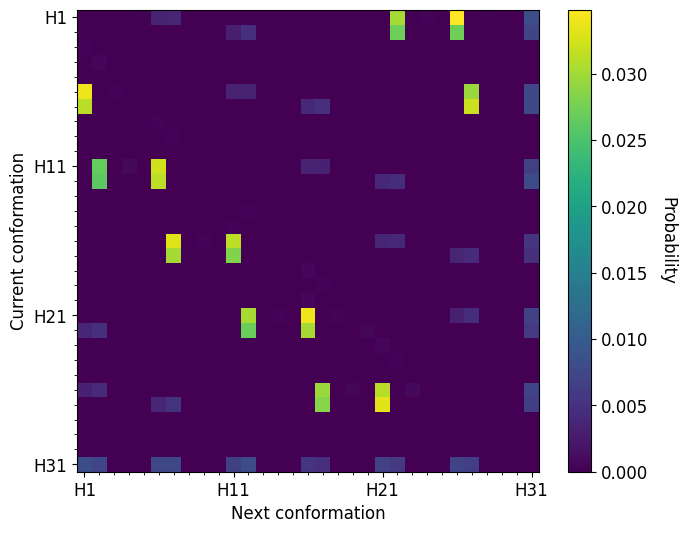

In [732]:
# plot the transition probabilities between different conformations
fig=plt.figure(figsize=(5*1.5,4*1.5))
ax=plt.subplot()
im=ax.imshow(conform_changes_percent,aspect='auto',interpolation='none')
ax.set_aspect(1)
ax.set_yticks([0,10,20,30])
ax.set_xticks([0,10,20,30])
minor_locator = MultipleLocator(1)
ax.xaxis.set_minor_locator(minor_locator)
ax.yaxis.set_minor_locator(minor_locator)
_=ax.set_xticklabels([f'H{i+1}' for i in [0,10,20,30]])
_=ax.set_yticklabels([f'H{i+1}' for i in [0,10,20,30]])
ax.set_xlabel('Next conformation')
ax.set_ylabel('Current conformation')
cbar=fig.colorbar(im)
cbar.set_label('Probability',rotation=270,labelpad=20)

# plt.savefig(f'pic/conform_transition_{filename}.png',dpi=300,bbox_inches='tight')
# plt.savefig(f'pic/conform_transition_{filename}.pdf',bbox_inches='tight')

In [733]:
# calculate the probabilities of nucleotide states change
last_num=1
conform_jumps=[((jj[0]+5*ii)%30,(jj[1]+5*ii)%30) for ii in range(6) for jj in [(0,21),(0,25),(1,21),(1,25)]]
nucleo_jumps=[(0,1),(1,2),(1,0),(2,0)]
density=np.zeros((6*len(nucleo_jumps),len(conform_jumps)))
conform_ids=conform_types+5*(conform_shifts%6)
for ii in range(len(conform_ids)-1):
    conform_id_now=conform_ids[ii]
    conform_id_next=conform_ids[ii+1]
    try:
        jj=conform_jumps.index((conform_id_now,conform_id_next))
        nucleos_now=nucleos_all[ii]
        count=0
        for kk in range(ii-1,-1,-1):
            if not np.all(nucleos_all[kk]==nucleos_now):
                count+=1
                if count==last_num:
                    for ll in range(6):
                        if nucleos_all[kk,ll]!=nucleos_now[ll]:
                            mm=nucleo_jumps.index((nucleos_all[kk,ll],nucleos_now[ll]))
                            density[mm*6+ll,jj]+=1
                    break
                else:
                    nucleos_now=nucleos_all[kk]
    except Exception:
        pass

density_norm=density/np.sum(density,axis=0)
density_rel=np.zeros_like(density_norm)
for ii in range(6):
    for jj in range(len(nucleo_jumps)):
        density_rel[jj*6:(jj+1)*6,ii*4:(ii+1)*4]=np.flipud(np.roll(density_norm[jj*6:(jj+1)*6,ii*4:(ii+1)*4],-ii,axis=0))

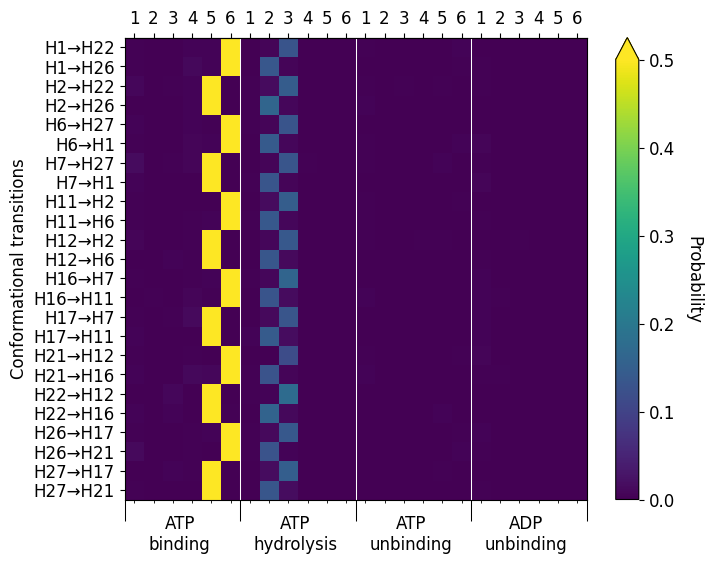

In [734]:
# plot the probabilities of nucleotide states change
if filename!='1e-5':
    vmax=0.5
    extend='max'
else:
    vmax=None
    extend='neither'

yticklabels=[f'H{ii[0]+1}→H{ii[1]+1}' for ii in conform_jumps]
xticklabels=['ATP\nbinding','ATP\nhydrolysis','ATP\nunbinding','ADP\nunbinding','']

fig=plt.figure(figsize=(5*1.5,4*1.5))
ax=plt.subplot()
im=ax.imshow(density_rel.T,aspect='auto',interpolation='none',vmax=vmax)
ax.set_aspect(1)

for i in range(len(xticklabels)-2):
    ax.plot([5.5+6*i,5.5+6*i],[-0.5,23.5],color='white',linewidth=0.75)

ax.set_yticks(np.arange(len(yticklabels)),yticklabels)
ax.set_xticks([-0.5,5.5,11.5,17.5,23.5],xticklabels)

ax.tick_params(axis='x',which='major',length=15,width=0.75)
minor_locator = MultipleLocator(1)
ax.xaxis.set_minor_locator(minor_locator)

offset = matplotlib.transforms.ScaledTranslation(0.55,0.1,fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform()+offset)

ax.set_ylabel('Conformational transitions')

cbar=fig.colorbar(im,extend=extend)
cbar.set_label('Probability',rotation=270,labelpad=20)

secax = ax.secondary_xaxis('top')
_=secax.set_xticks(range((len(xticklabels)-1)*6),list(range(1,7))*(len(xticklabels)-1))

# plt.savefig(f'pic/last_event_{filename}.png',dpi=300,bbox_inches='tight')
# plt.savefig(f'pic/last_event_{filename}.pdf',bbox_inches='tight')